# Digits

This notebook one-vs-all logistic regression and neural networks to recognize hand-written digits. 

## 1 - Overview of the data set ##

The dataset contains 5000 training examples of handwritten digits. This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/).

Each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

The original dataset has its own format and you need to write your own program to read it but this dataset has already been converted into the Matlab format for Andrew Ng's wonderful course of Machine Learning at Stanford.

Let's get more familiar with the dataset.

In [1]:
from scipy.io import loadmat

dataset = loadmat('../datasets/mnist-data.mat') # comes as dictionary
dataset.keys()

dict_keys(['y', 'X', '__globals__', '__header__', '__version__'])

### Visualise the data

Each line of X is an array representing an image. You can visualize an example by running the following code. Feel free also to change the `indexImage` value and re-run to see other images. 

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import numpy as np
    # Example of a picture
indexImage = 4000  # try any index between 0 and 4999. They are sorted, from 1 to 10 (=0)
renderImage = np.reshape(dataset['X'][indexImage], (20,20))
labelImage = dataset['y'][indexImage]

Label: this is a  [8]


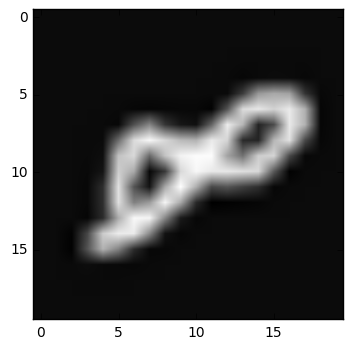

In [4]:
plt.imshow(renderImage, cmap='gray')
print ("Label: this is a ", labelImage)

## 2 - Data preprocessing

**Dataset pre-processing:**

* Figure out the dimensions and shapes of the problem 
* Split the dataset into training a test subsets
* "Standardise" the data

In [5]:
X = dataset['X'] # the images
X.shape

(5000, 400)

The second part of the training set is a 5000-dimensional vector y that contains labels for the training set. 

In [6]:
y = dataset['y'] # the labels
y.shape

(5000, 1)

In [7]:
y[499]

array([10], dtype=uint8)

One problem: The label representing the digit 0 (zero) is coded as ten (10). Change this.

In [8]:
list_y = [0 if i == 10 else i for i in y] # apply to each item in y
y = np.asarray(list_y)
y = y.reshape(-1,1)
y.shape

(5000, 1)

In [9]:
y[0:10]  # verify that the label is now zero

array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

### One hot encoding

Another problem: the original labels (in the variable y) are a number between 0, 1, 2, ..., 9.  
For the purpose of training a neural network, we need to recode the labels as vectors containing only binary values 0 or 1. 

In [10]:
n_classes = 10 # 10 digits = 10 classes/labels

In [11]:
# np.eye(n) creates an identity matrix of shape (n,n)
OHE_y = np.eye(n_classes)[y.reshape(-1)]
OHE_y.shape

(5000, 10)

In [12]:
OHE_y[1000] # this is the new encoding for e.g. label = 2

array([ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

### Split into train and test sets

Split into 20% of test and 80% of train sets

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, OHE_y, test_size=0.2, random_state=7)

In [14]:
input_layer_size  = X.shape[1]  
num_px = np.sqrt(input_layer_size) # 400 = 20x20 Input Images of Digits
n_y = y_train.shape[1]
m_train = X_train.shape[0]
m_test = X_test.shape[0]

In [15]:
print ("Dataset dimensions:")
print ("Number of training examples = " + str(m_train))
print ("Number of testing examples = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: <" + str(num_px) + ", " + str(num_px) + ">")
print ("X train shape: " + str(X_train.shape))
print ("y train shape: " + str(y_train.shape))

Dataset dimensions:
Number of training examples = 4000
Number of testing examples = 1000
Height/Width of each image: num_px = 20.0
Each image is of size: <20.0, 20.0>
X train shape: (4000, 400)
y train shape: (4000, 10)


## 3 - Deep Neural Network for Image Classification

Now we will build and apply a deep neural network to the problem.

### Building the parts of our algorithm ## 

The main steps for building a Neural Network are as usual:
1. Define the model structure (such as number and size of layers) and the hyperparameters
1. Initialize the model's weights
1. Loop for the number of iterations:
    - Calculate current loss (forward propagation)
    - Calculate current gradient (backward propagation)
    - Update parameters (gradient descent)
1. Use the trained weights to predict the labels

### Defining the neural network structure

Our neural network has 3 layers – an input layer, a hidden layer and an output layer.  
Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1).  
There are 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).  

In [16]:
### CONSTANTS DEFINING THE MODEL ####
    # we define a neural network with total 3 layers, x, y and 1 hidden:
n_h = 25
nn_layers = [input_layer_size, n_h, n_y]  # length is 3 (layers)

### Build the 3-layer neural network

We will re-use all the helper functions defined previously to build the neural network, such as the linear forward and the backward propagation.  
Please refer to the Python file _nn_helpers.py_ for the details.

In [17]:
from nn_helpers import *

In [18]:
# automatically reload the imported module in case of changes
%load_ext autoreload
%autoreload 2

Now we can put together all the functions to build a 3-layer neural network with this structure:

In [19]:
nn_layers

[400, 25, 10]

In [20]:
np.random.seed(1)

In [21]:
train_set_x = X_train.T
train_set_x.shape

(400, 4000)

In [22]:
# y is the original output array, with labels
# train_set_y is that set, one-hot-encoded
train_set_y = y_train.T
train_set_y.shape

(10, 4000)

In [76]:
#  FUNCTION: L_layer_model

def simpleNN_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px)
    Y -- true "label" vector (containing 0 or 1), of shape (10, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimisation loop
    print_cost -- if True, it prints the cost every 200 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []      # keep track of cost
    iterations2cost = 200 # Print the cost every these iterations
    
    # Parameters initialization.
    parameters = initialise_parameters(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
    
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every iterations2cost training example
        if print_cost and i % iterations2cost == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % iterations2cost == 0:
            costs.append(cost)
           
    if print_cost:
        # plot the cost
        fig, ax = plt.subplots(1,1)
        plt.plot(np.squeeze(costs))

        ticks = ax.get_xticks()
        ax.locator_params(axis='x', nticks=len(costs))
        ax.set_xticklabels([int(x*iterations2cost) for x in ticks])
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

We will now train the model as a 3-layer neural network.
Run the cell below to train the model. The cost should decrease on every iteration. It may take up to 5 minutes to run 3500 iterations.
You can click on the square (⬛) on the upper bar of the notebook to stop the cell.

Cost after iteration 0: 7.066646
Cost after iteration 200: 0.620103
Cost after iteration 400: 0.462519
Cost after iteration 600: 0.380703
Cost after iteration 800: 0.324154
Cost after iteration 1000: 0.279849
Cost after iteration 1200: 0.243783
Cost after iteration 1400: 0.213618
Cost after iteration 1600: 0.188009
Cost after iteration 1800: 0.165912
Cost after iteration 2000: 0.147390
Cost after iteration 2200: 0.131615
Cost after iteration 2400: 0.118221
Cost after iteration 2600: 0.106611
Cost after iteration 2800: 0.096398
Cost after iteration 3000: 0.087402
Cost after iteration 3200: 0.079491
Cost after iteration 3400: 0.072593


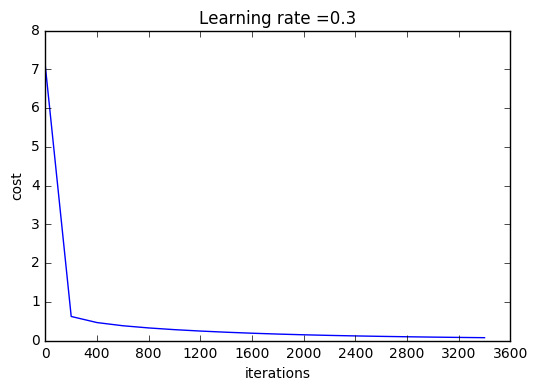

In [77]:
fit_params = simpleNN_model(train_set_x, train_set_y, nn_layers, learning_rate = 0.3, num_iterations = 3500, print_cost = True)

## 4. Results analysis

Now we can check the performance of the trained network by predicting the results of the test set and comparing them with the actual labels.  
Note that the predict() function has been adapted to cope with the multi-class labels.

In [78]:
def predict(X, yOHE, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    It also checks them against the true labels and print the accuracy
    Arguments:
    X -- data set of examples you would like to label
    yOHE -- the true labels, as multi-class vectors
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions (the label) for the given dataset X 
    """
    
    m = X.shape[1]
    nLabels = yOHE.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1, m)) # the predicted output, initialised to zero
    y = np.zeros((1, m)) # the actual output
     
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    # probas is a matrix of shape [nLabels, m] (one-hot-encoded)
    assert (probas.shape[1] == m)
    
    for i in range(0, m):
            # convert probs to label predictions:
            # just take the label with max prob
        p[0,i] = np.argmax(probas[:,i])

        # convert expected results into label: takes the value with one
        y[0,i] = np.argmax(yOHE[:,i])
        
    # print results
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [79]:
print ("On the training set:")
predictions_train = predict(train_set_x, train_set_y, fit_params)
print ("On the test set:")
predictions_test = predict(X_test.T, y_test.T, fit_params)

On the training set:
Accuracy: 0.99825
On the test set:
Accuracy: 0.938


## 5 - Initializing parameters

There are two types of parameters to initialize in a neural network:
- the weight matrices $W^{[i]}$
- the bias vectors $b^{[i]}$

The weight matrix is initialised with random values while the bias vector as a vector of zeros.  
In general, initializing all the weights to zero results in the network failing to **break symmetry**. This means that every neuron in each layer will learn the same thing and the network is no more powerful than a linear classifier such as logistic regression.  

To break symmetry, we initialise the weights randomly. Following random initialisation, each neuron can then proceed to learn a different function of its inputs.  
Of course, different initializations lead to different results and poor initialisation can slow down the optimisation algorithm.  

One good practice is not to initialise to values that are too large, instead what bring good results are the so-called [Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf) or the [He (for ReLU activation) initialisations](https://www.cv-foundation.org/openaccess/content_iccv_2015/papers/He_Delving_Deep_into_ICCV_2015_paper.pdf). 

Finally, we try here the "He Initialization"; this is named for the first author of He et al., 2015. (If you have heard of "Xavier initialization", this is similar except Xavier initialization uses a scaling factor for the weights $W^{[l]}$ of `sqrt(1./layers_dims[l-1])` where He initialization would use `sqrt(2./layers_dims[l-1])`.)

This function is similar to the previous `initialize_parameters_random(...)`. The only difference is that instead of multiplying `np.random.randn(..,..)` by 10, you will multiply it by $\sqrt{\frac{2}{\text{dimension of the previous layer}}}$, which is what He initialization recommends for layers with a ReLU activation. 

In [80]:
#  FUNCTION: initialize_parameters

def initialise_parameters_he(layer_dims):
    """
    Arguments:
    layer_dims -- python array (list) containing the dimensions of each layer in our network
    
    Returns:
    parameters -- python dictionary containing the parameters "W1", "b1", ..., "WL", "bL":
                    Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
                    bl -- bias vector of shape (layer_dims[l], 1)
    """
    
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1])*np.sqrt(2./layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
            # unit tests
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

        
    return parameters

## 6 - L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**.  
It consists of appropriately modifying your cost function, from:  

$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)}$$
  
To:  

$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost}$$

In [81]:
# GRADED FUNCTION: compute_cost_with_regularization

def compute_cost_with_regularisation(A3, Y, parameters, lambdaHyper):
    """
    Implement the cost function with L2 regularization. See formula (2) above.
    
    Arguments:
    A3 -- post-activation, output of forward propagation, of shape (output size, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    parameters -- python dictionary containing parameters of the model
    lambdaHyper -- the lambda regularisation hyper-parameter.
    
    Returns:
    cost - value of the regularized loss function (formula (2))
    """
        # This gives you the cross-entropy part of the cost
    cross_entropy_cost = compute_cost(A3, Y) 
   
    sum_regularization_cost = 0
    m = Y.shape[1]
    L = len(parameters) // 2    # number of layers (2 because we have W and b)    
    
    for i in range(1, L+1):
        W_i = parameters['W' + str(i)] 
        sum_regularization_cost += np.sum(np.square(W_i))
    
    regularization_cost = (1/m)*(lambdaHyper/2)*(sum_regularization_cost) 
    
    cost = cross_entropy_cost + regularization_cost
    
    return cost

In [82]:
def compute_cost_with_regularisation_test_case():

    np.random.seed(1)
    Y_assess = np.array([[1, 1, 0, 1, 0]])
    W1 = np.random.randn(2, 3)
    b1 = np.random.randn(2, 1)
    W2 = np.random.randn(3, 2)
    b2 = np.random.randn(3, 1)
    W3 = np.random.randn(1, 3)
    b3 = np.random.randn(1, 1)

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2, "W3": W3, "b3": b3}
    a3 = np.array([[ 0.40682402,  0.01629284,  0.16722898,  0.10118111,  0.40682402]])

    cost = compute_cost_with_regularisation(a3, Y_assess, parameters, lambdaHyper = 0.1)
    
    np.testing.assert_approx_equal(cost, 1.78649, significant=5)
    
    return "OK"

compute_cost_with_regularisation_test_case()

'OK'

Of course, because we changed the cost, we have to change backward propagation as well!  
All the gradients have to be computed with respect to this new cost: add the regularization term's gradient.

In [83]:
def backward_propagation_with_regularisation(X, Y, Yhat, caches, lambdaHyper):
    """
    Implements the backward propagation of our baseline model to which we added an L2 regularization.
    
    Arguments:
    X -- input dataset, of shape (input size, number of examples)
    Yhat -- "true" labels vector, of shape (output size, number of examples)
    caches -- cache output from forward_propagation()
    lambdaHyper -- regularization hyperparameter, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]


    L = len(caches) # the number of layers
    gradients = {}

    
    last_layer_cache = caches[L-1]
    ((A, W, b), Z) = last_layer_cache

    assert (Yhat.shape == Y.shape)


    dZ = Yhat - Y
    gradients["dZ" + str(L)] = dZ

    
    for i in reversed(range(L-1)):
        current_layer_cache = caches[i]
        ((A_prev, W_prev, b_prev), Z_prev) = current_layer_cache
        

        dW_entropy = 1./m * np.dot(dZ, A.T)
        dW_reg = (lambdaHyper/m)*W
        dW = dW_entropy + dW_reg
        
        db = 1./m * np.sum(dZ, axis=1, keepdims = True)

        dA_prev = np.dot(W.T, dZ)
        dZ_prev = np.multiply(dA_prev, np.int64(A > 0))
        
        gradients["dW" + str(i + 2)] = dW
        gradients["db" + str(i + 2)] = db
        
        gradients["dA" + str(i + 1)] = dA_prev
        gradients["dZ" + str(i + 1)] = dZ_prev
        
        ((A, W, b), Z) = ((A_prev, W_prev, b_prev), Z_prev)
        dZ = dZ_prev
        
        # finally add the gradients for the first layer
    dW_prev = 1./m * np.dot(dZ_prev, X.T) + (lambdaHyper/m)*W_prev
    db_prev = 1./m * np.sum(dZ_prev, axis=1, keepdims = True)  
    
    gradients["dW1"] = dW_prev
    gradients["db1"] = db_prev
    
    return gradients

### Putting all together

In [85]:
def NN_model(X, Y, layers_dims, learning_rate = 0.0075, 
             num_iterations = 3000, print_cost=False, 
             lambdaHyper = 0, init="standard"):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    lambdaHyper -- regularisation hyperparameter, scalar
    init -- type of initialisation: standard or He.



    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []  # keep track of cost
    iterations2cost = 200 # Print the cost every these iterations

    
    # Parameters initialization.
    if init == "he":
        parameters = initialise_parameters_he(layers_dims)
    else:
        parameters = initialise_parameters(layers_dims)

    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        Yhat, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        if lambdaHyper == 0:
            cost = compute_cost(Yhat, Y)
        else:
            cost = compute_cost_with_regularisation(Yhat, Y, parameters, lambdaHyper)            
    
        # Backward propagation.
        if lambdaHyper == 0:
            grads = L_model_backward(Yhat, Y, caches)
        else:
            grads = backward_propagation_with_regularisation(X, Y, Yhat, caches, lambdaHyper)


 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every iterations2cost training example
        if print_cost and i % iterations2cost == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % iterations2cost == 0:
            costs.append(cost)
           
    if print_cost:
        # plot the cost
        fig, ax = plt.subplots(1,1)
        plt.plot(np.squeeze(costs))

        ticks = ax.get_xticks()
        ax.locator_params(axis='x', nticks=len(costs))
        ax.set_xticklabels([int(x*iterations2cost) for x in ticks])

        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()
    
    return parameters

Cost after iteration 0: 8.494136
Cost after iteration 200: 0.711390
Cost after iteration 400: 0.592396
Cost after iteration 600: 0.535481
Cost after iteration 800: 0.500674
Cost after iteration 1000: 0.476576
Cost after iteration 1200: 0.459300
Cost after iteration 1400: 0.446412
Cost after iteration 1600: 0.436147
Cost after iteration 1800: 0.427111
Cost after iteration 2000: 0.419631
Cost after iteration 2200: 0.413469
Cost after iteration 2400: 0.408086
Cost after iteration 2600: 0.403281
Cost after iteration 2800: 0.398824
Cost after iteration 3000: 0.394866
Cost after iteration 3200: 0.391269
Cost after iteration 3400: 0.388094


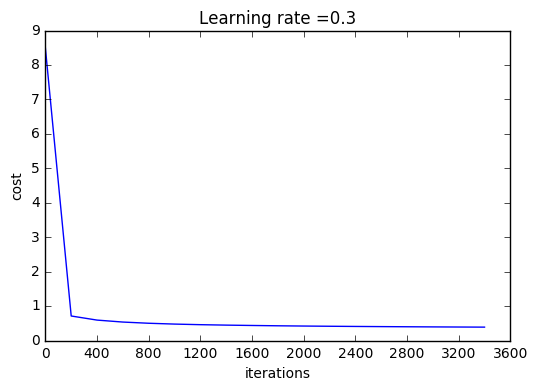

In [86]:
fit_params_reg = NN_model(train_set_x, train_set_y, nn_layers, 
                      learning_rate = 0.3, num_iterations = 3500, print_cost = True,
                      lambdaHyper = 5, init="he")

Let's check the new accuracy values:

In [87]:
print ("On the training set:")
predictions_train = predict(train_set_x, train_set_y, fit_params_reg)
print ("On the test set:")
predictions_test = predict(X_test.T, y_test.T, fit_params_reg)

On the training set:
Accuracy: 0.9855
On the test set:
Accuracy: 0.939


## 7 - Dropout

Finally, **dropout** is a widely used regularization technique that is specific to deep learning.   
**It randomly shuts down some neurons in each iteration.** 

When you shut some neurons down, you actually modify your model. The idea behind drop-out is that at each iteration, you train a different model that uses only a subset of your neurons. With dropout, your neurons thus become less sensitive to the activation of one other specific neuron, because that other neuron might be shut down at any time. 



In [88]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    """
    Implements the forward propagation: LINEAR -> RELU + DROPOUT -> LINEAR -> RELU + DROPOUT -> LINEAR -> SIGMOID.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    parameters -- python dictionary containing the parameters of a 3-layers network.
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    A2 -- last activation value, output of the forward propagation, of shape (1,1)
    cache -- tuple, information stored for computing the backward propagation
    """
    L = len(parameters) // 2                  # number of layers in the neural network

    
        
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1,cache_temp = relu(Z1)

    D1 = np.random.rand(A1.shape[0], A1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = D1 < keep_prob     # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    A1 = A1*D1                                 # Step 3: shut down some neurons of A1
    A1 = A1 / keep_prob                         # Step 4: scale the value of neurons that haven't been shut down

    Z2 = np.dot(W2, A1) + b2
    A2, cache_temp = sigmoid(Z2)
    
    caches = (Z1, D1, A1, W1, b1, Z2, A2, W2, b2)
    
    return A2, caches

In [89]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    """
    Implements the backward propagation of our baseline model to which we added dropout.
    
    Arguments:
    X -- input dataset, of shape (2, number of examples)
    Y -- "true" labels vector, of shape (output size, number of examples)
    cache -- cache output from forward_propagation_with_dropout()
    keep_prob - probability of keeping a neuron active during drop-out, scalar
    
    Returns:
    gradients -- A dictionary with the gradients with respect to each parameter, activation and pre-activation variables
    """
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, A2, W2, b2) = cache

    
    dZ2 = A2 - Y
    
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1*D1              # Step 1: Apply mask D1 to shut down the same neurons as during the forward propagation
    dA1 = dA1 / keep_prob       # Step 2: Scale the value of neurons that haven't been shut down

    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

In [90]:
def NN_model_drop(X, Y, layers_dims, learning_rate = 0.0075, 
             num_iterations = 3000, print_cost=False, 
             keep_prob = 1, init="standard"):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (number of examples, num_px * num_px * 3)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    costs = []  # keep track of cost
    iterations2cost = 200 # Print the cost every these iterations

    # Parameters initialization.
    if init == "he":
        parameters = initialise_parameters_he(layers_dims)
    else:
        parameters = initialise_parameters(layers_dims)

    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        Yhat, caches = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Compute cost.
        cost = compute_cost(Yhat, Y)
    
        # Backward propagation.
        grads = backward_propagation_with_dropout(X, Y, caches, keep_prob)


 
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
                
        # Print the cost every iterations2cost training example
        if print_cost and i % iterations2cost == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % iterations2cost == 0:
            costs.append(cost)
           
    if print_cost:
        # plot the cost
        fig, ax = plt.subplots(1,1)
        plt.plot(np.squeeze(costs))

        ticks = ax.get_xticks()
        ax.locator_params(axis='x', nticks=len(costs))
        ax.set_xticklabels([int(x*iterations2cost) for x in ticks])
        plt.ylabel('cost')
        plt.xlabel('iterations')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

    
    return parameters

Cost after iteration 0: 6.637041
Cost after iteration 200: 0.872340
Cost after iteration 400: 0.686235
Cost after iteration 600: 0.590146
Cost after iteration 800: 0.544884
Cost after iteration 1000: 0.510920
Cost after iteration 1200: 0.478561
Cost after iteration 1400: 0.451083
Cost after iteration 1600: 0.420292
Cost after iteration 1800: 0.402299
Cost after iteration 2000: 0.380131
Cost after iteration 2200: 0.371170
Cost after iteration 2400: 0.373264
Cost after iteration 2600: 0.351920
Cost after iteration 2800: 0.341553
Cost after iteration 3000: 0.338320
Cost after iteration 3200: 0.331876
Cost after iteration 3400: 0.322079


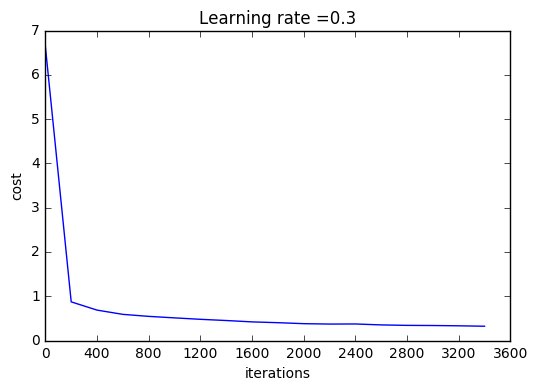

On the train set:
Accuracy: 0.98675
On the test set:
Accuracy: 0.928


In [91]:
fit_params_drop = NN_model_drop(train_set_x, train_set_y, nn_layers, 
                            learning_rate = 0.3, num_iterations = 3500, print_cost = True,
                            keep_prob = 0.8, init="he")

print ("On the train set:")
predictions_train = predict(train_set_x, train_set_y, fit_params_drop)
print ("On the test set:")
predictions_test = predict(X_test.T, y_test.T, fit_params_drop)

Even higher accuracy could be obtained, by systematically searching for better hyperparameters (learning_rate, layers_dims, num_iterations).